In [1]:
%pylab inline

from scipy.optimize import root_scalar
from scipy.integrate import trapezoid

Populating the interactive namespace from numpy and matplotlib


First, let's make a "qubit". This isn't a rigorous definition of a qubit, instead, we only define it with everything we need for this experiment. To this end, I have encoded the qubit's rotation around the y-axis as an intrinsic property of the qubit. This means that the qubit is being rotated around the $y$-axis on a time scale, which gives the qubit an internal "probability" of being measured in the $\lvert 1 \rangle$ state, depending on what time (after the rotation begins) you measure the qubit.

In [2]:
class Qubit:
    def __init__(self, seed, alpha, beta, phi0, c):
        self.alpha = alpha
        self.beta = beta
        self.phi0 = phi0
        self.c = c
        
        self.prob = lambda t: alpha / 2 * (1 - np.cos(c * t + phi0)) + beta
        
        self.rng = np.random.default_rng(seed)
        
    def measure(self, t, n=1):
        # The n parameter allows us to run multiple measurements for the same time step
        # with one function call. This speeds up the computation a bit.
        v = self.rng.random(size=n)
        p = self.prob(t)
        
        # "less than" ensures the probability actually works as intended
        return np.where(v < p, 1, 0)

We are going to assume these qubits are "ideal", that is $\alpha = 1$ and $\beta = \phi_0 = 0$. Additionally, we assume that we also know the approximate period of $P(t)$, and that is approximately 6. You could do the math on what this means, but in essence, we also assume that $c=1$. This can be verified by the fact that we hope to find pi by finding the two times that the $\lvert 1 \rangle$ probability $= 0.5$, which should occur at $t = \pi/2c$ and $t=3\pi/2c$.

In [3]:
q1 = Qubit(123, 1, 0, 0, 1)

Now we run the measurement. The paper indicates that they made 8192 ($2^{13}$) measurements on each qubit at **each** time step, from 0 to 6.3 with a step of 0.1. Thankfully I included an $n$ parameter in my qubits, so we can do all 8192 measurements with a single call. So we loop over the time steps, and then over the qubits to do it on all qubits.

In [4]:
time_steps = np.arange(0, 6.3, 0.1)

vals = []
n_measure = 8192
for t in time_steps:
    m = q1.measure(t, n_measure)
    frac = np.sum(m) / len(m)
    vals.append(frac)
    
f = np.asarray(vals)

Now engage the algorithm. We estimate $\alpha$ and $\beta$ as $\hat{\alpha}$ and $\hat{\beta}$. Then renormalize the fractions to have a range of 0 and 1. I then define the linear interpolation of the function to find our estimated $t_1$ and $t_2$. (Steps 1-3 of the algorithm, page 3 in the paper). I do one modification, however.

In [5]:
beta_hat = np.min(vals)
alpha_hat = np.max(vals) - beta_hat

f1 = (f - beta_hat) / alpha_hat
f1_interp = lambda x: np.interp(x, time_steps, f1)

alpha_hat, beta_hat

(0.9996337890625, 0.0)

Now we want to find where $\tilde{f_1} \approx 0.5$, close to $t_1 = 1.5$ and $t_2 = 4.5$. (Step 4 in the paper). here I define an $f_2$ interpolation that is simply $f_1 - 0.5$ for root finding purposes, since the root finder looks for 0's.

In [6]:
f2 = lambda x: np.interp(x, time_steps, f1) - 0.5

t1 = root_scalar(f2, x0=1.5, x1=2).root
t2 = root_scalar(f2, x0=4.5, x1=5).root

t1, t2

(1.5899999999999999, 4.727108433734941)

Next we refine our estimates of $\hat{\alpha}$ and $\hat{\beta}$ and renormalize the function, generating a new interpolated function. (Steps 5 and 6 in the paper). When finding these new estimates we require a "refinement" step parameter $\delta$ which in the paper is chosen to be 0.1.

In [7]:
delta = 0.1

t_maxval = (t1 + t2) / 2
t_minval = t_maxval + (t2 - t1)

# Indices of time steps that satisfy this condition
tmax = np.where(np.abs((time_steps - t_maxval)) < delta)[0]
tmin = np.where(np.abs((time_steps - t_minval)) < delta)[0]

beta_hat = np.mean(f1[tmin])
alpha_hat = np.mean(f1[tmax]) - beta_hat

f1 = (vals - beta_hat) / alpha_hat
f1_interp = lambda x: np.interp(x, time_steps, f1)

alpha_hat, beta_hat

(0.9984125045793137, 0.0015874954206862866)

We have to refine our estimates of $t_1$ and $t_2$. This step (Step 7 in the paper) is three sub steps: Find all $t$ within 0.5 of the $t_i$, fit a linear function to the $f_1$ values for those $t$ values, and find where that linear fit equals $0.5$.

In [8]:
# Indices of time steps that fulfill the above condition.
t1_idx = np.where(np.abs((time_steps - t1)) < 0.5)[0]
coeff_1 = np.polyfit(time_steps[t1_idx], f1[t1_idx], 1)

# Once again subtracting 0.5 to find where the function = 0.5 not 0.
fit_1 = lambda x: coeff_1[0] * x + coeff_1[1] - 0.5
t1_hat = root_scalar(fit_1, x0=1.5, x1=2).root

# Indices of time steps that fulfill the above condition.
t2_idx = np.where(np.abs((time_steps - t2)) < 0.5)[0]
coeff_2 = np.polyfit(time_steps[t2_idx], f1[t2_idx], 1)

# Once again subtracting 0.5 to find where the function = 0.5 not 0.
fit_2 = lambda x: coeff_2[0] * x + coeff_2[1] - 0.5
t2_hat = root_scalar(fit_2, x0=1.5, x1=2).root


t1_hat, t2_hat

(1.5784831463853437, 4.717912119773024)

Finaly we estimate the integral between $t_1$ and $t_2$ using the trapezoidal rule, which then gives us an estimate of $\pi$ via $\pi \approx \frac{t_2 - t_1}{I}$ (Steps 8 and 9 in the paper).

In [9]:
f_hat = lambda x: np.interp(x, time_steps, f)

# Adding the t1 and t2 to the measured timesteps for integration purposes.
t_idx = np.where((time_steps >= t1) & (time_steps <= t2))[0]
t_integ = time_steps[t_idx]
t_integ = np.insert(t_integ, 0, t1_hat)
t_integ = np.append(t_integ, t2_hat)

# Doing the same for the probability measured values
y_integ = f[t_idx]
y_integ = np.insert(y_integ, 0, f_hat(t1_hat))
y_integ = np.append(y_integ, f_hat(t2_hat))

# Trapezoidal rule on the given points
I = np.trapz(y_integ - 0.5, t_integ)

# And the final guess!
pi_guess = (t2_hat - t1_hat) / I
pi_guess

3.134403704592276

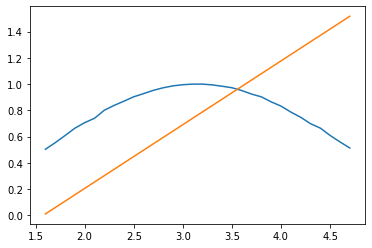

In [10]:
plt.plot(time_steps[t_idx], f1[t_idx])
plt.plot(time_steps[t_idx], fit_1(time_steps[t_idx]))

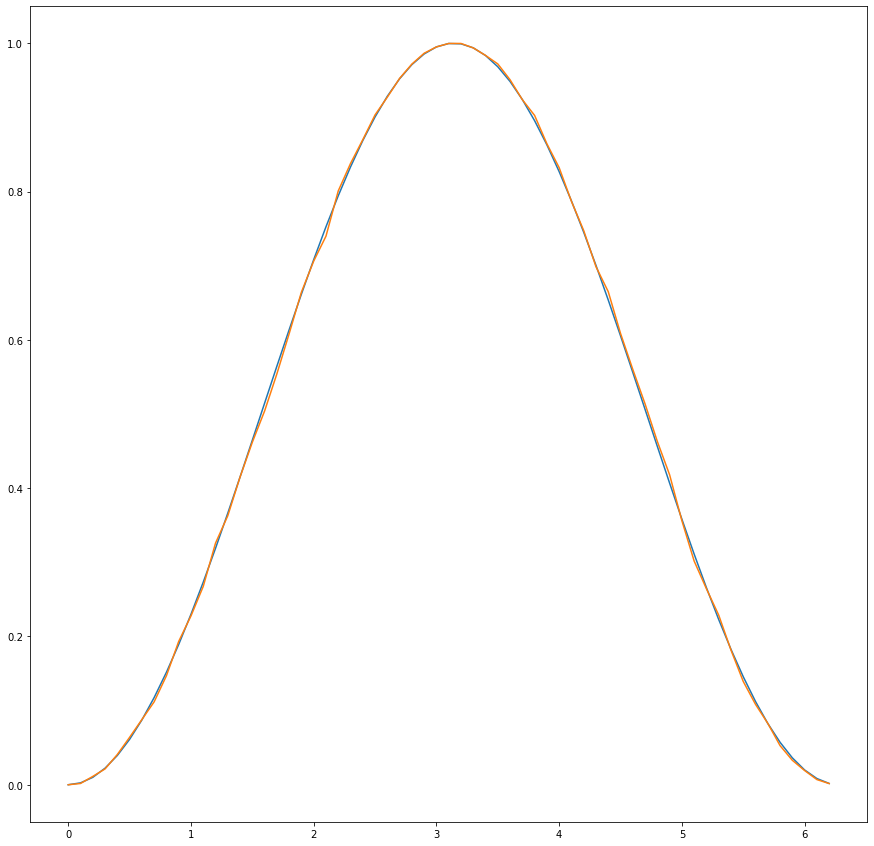

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))

c = 1
f = lambda t: 0.5 * (1 - np.cos(t))
plt.plot(time_steps, f(time_steps))
plt.plot(time_steps, vals)